This notebook shows a very simple neuronal network to solve PIMA classification problem

## Import statements

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from helpers import *

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score

from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import seaborn as sns

from itertools import count

%matplotlib inline

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## Import dataset

In [13]:
# Read the dataset
data = load_dataset()

# Preprocess the dataset
preprocess(data)

# Split dataset in two arrays: X for features and y for labels
X = get_features(data)
y = get_outcome(data)
y_cat = get_categorical_outcome(data)

## Build our neural network

In [22]:
def build_model():
    model = Sequential(name='PIMA classifier')

    # Input layer 
    model.add(Dense(units=16, activation='relu', use_bias=True, input_shape=(X.shape[1],), name='Input_Layer'))

    # Hidden layers
    model.add(Dense(units=16, activation='relu', use_bias=True, name='Hidden_Layer1'))

    # Output layer
    model.add(Dense(units=2, activation='softmax', use_bias=True, name='Output_Layer'))

    # Loss function
    loss = 'categorical_crossentropy'

    # Optimizer
    optimizer = SGD(lr=0.02)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

### Print model summary

In [23]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 16)                144       
_________________________________________________________________
Hidden_Layer1 (Dense)        (None, 16)                272       
_________________________________________________________________
Output_Layer (Dense)         (None, 2)                 34        
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


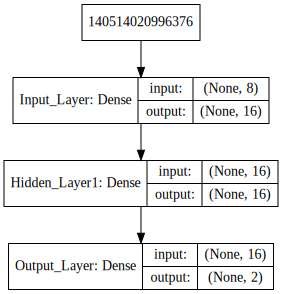

In [25]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## Cross-validate the model

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [30]:
model = KerasClassifier(build_fn=build_model, epochs=20, verbose=False)

cv = RepeatedStratifiedKFold(4, 3, random_state=13)
cv_results = cross_validate(model, X_train, y_train, scoring=['accuracy', 'precision', 'recall'], cv=cv, return_train_score=True);

In [31]:
cv_metrics = pd.DataFrame(data=cv_results).drop(columns=['score_time', 'fit_time'])

### Show the results

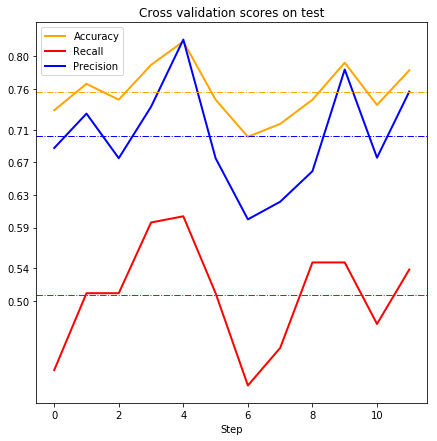

In [32]:
plt.figure(figsize=(7,7))

plt.plot(cv_metrics['test_accuracy'], color='Orange', linewidth=2)

plt.plot(cv_metrics['test_recall'], color='Red', linewidth=2)
plt.plot(cv_metrics['test_precision'], color='Blue', linewidth=2)

plt.axhline(cv_metrics['test_accuracy'].mean(), color='Orange', linewidth=1, linestyle='-.')
plt.axhline(cv_metrics['test_recall'].mean(), color='Red', linewidth=1, linestyle='-.')
plt.axhline(cv_metrics['test_precision'].mean(), color='Blue', linewidth=1, linestyle='-.')

plt.yticks(np.round(np.linspace(0.5, 0.8, 8), 2))
plt.title('Cross validation scores on test')
plt.xlabel('Step')
plt.legend(['Accuracy', 'Recall', 'Precision']);

In [ ]:

pd.DataFrame({
    'Mean':cv_metrics.mean(),
    'Standard Deviation':cv_metrics.std()
})


## Final prediction using test set

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=13)
model = build_model()
history = model.fit(X_train, y_train, epochs=50, verbose=False, validation_split=0.1)

In [47]:
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

### Print the results

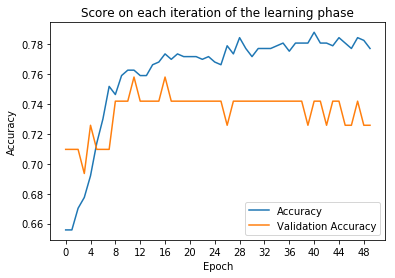

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0, 50, 4));
plt.title('Score on each iteration of the learning phase')
plt.legend(['Accuracy', 'Validation Accuracy']);

In [55]:
print("Accuracy on train set: {}".format(accuracy_score(y_train[:,1], y_train_pred).round(3)))
print("Classification report on train set: ")
print(classification_report(y_train[:,1], y_train_pred))

Accuracy on train set: 0.78
Classification report on train set: 
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84       403
         1.0       0.72      0.58      0.65       211

   micro avg       0.78      0.78      0.78       614
   macro avg       0.76      0.73      0.74       614
weighted avg       0.77      0.78      0.77       614



In [56]:
print("Accuracy on test set: {}".format(accuracy_score(y_test[:,1], y_test_pred).round(3)))
print("Classification report on test set: ")
print(classification_report(y_test[:,1], y_test_pred))

Accuracy on test set: 0.76
Classification report on test set: 
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.82        97
         1.0       0.74      0.54      0.63        57

   micro avg       0.76      0.76      0.76       154
   macro avg       0.75      0.72      0.72       154
weighted avg       0.76      0.76      0.75       154



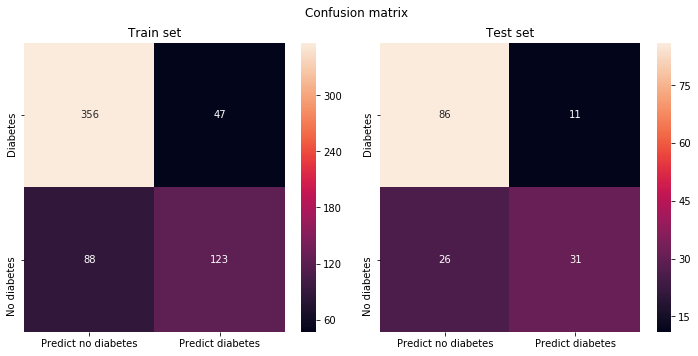

In [59]:
cm_train = pd.DataFrame(confusion_matrix(y_train[:,1], y_train_pred), columns=['Predict no diabetes', 'Predict diabetes'],
                 index=['Diabetes', 'No diabetes'])

cm_test = pd.DataFrame(confusion_matrix(y_test[:,1], y_test_pred), columns=['Predict no diabetes', 'Predict diabetes'],
                 index=['Diabetes', 'No diabetes'])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(ax[0])
sns.heatmap(cm_train, annot=True, fmt='d')
plt.title('Train set')
plt.sca(ax[1])
sns.heatmap(cm_test, annot=True, fmt='d')
plt.title('Test set')

plt.suptitle('Confusion matrix')
plt.tight_layout()
plt.subplots_adjust(top=0.88)